# Importing the Libraries

In [91]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses
import numpy as np

In [2]:
print(tf.__version__)

2.9.1


In [3]:
dataset_directory = 'aclImdb_v1/aclImdb'

In [4]:
os.listdir(path = dataset_directory)           #kist of directory that exists in the data

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.listdir(os.path.join(dataset_directory , 'train'))   
train_dir #files in the train directoryb

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(dataset_directory, 'train/pos/1181_9.txt')

with open(sample_file ) as f:             # An opinion from user in IMDB
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Reading data from directory

In [7]:
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb_v1/aclImdb/train' , batch_size = batch_size , seed = seed ,
                                                     subset = 'training' , validation_split = 0.2 )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
print(train_ds.class_names)       

['neg', 'pos']


In [9]:
for text_batch , label_batch in train_ds.take(1):
    for i in range(3):
        print('review' , text_batch.numpy()[i])
        print()
        print('label' , label_batch.numpy()[i])

review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

label 0
review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into

In [10]:
print("Label 0 corresponds to", train_ds.class_names[0])     #first element
print("Label 1 corresponds to", train_ds.class_names[1])     #second element

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb_v1/aclImdb/train' , seed = seed , subset = 'validation' ,
                                                   validation_split = 0.2 , batch_size = batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb_v1/aclImdb/test' , seed = seed , 
                                                   batch_size = batch_size)

Found 25000 files belonging to 2 classes.


# Preprocessing


In [13]:
def custom_standardization(input_data):         
    lowercase = tf.strings.lower(input_data)
    strip_html = tf.strings.regex_replace(lowercase , '<br />' , '')   # replace all the html tag in my text
    
    return tf.strings.regex_replace(strip_html , '[%s]' %re.escape(string.punctuation) , '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization , 
                                          max_tokens = max_features , output_mode = 'int' , 
                                          output_sequence_length = sequence_length)


In [15]:
train_text = train_ds.map(lambda x , y  : x)        #only label
vectorize_layer.adapt(train_text)                   #apply this vectorization only on my labels 

In [16]:
def vectorize_text(text , label):
    text = tf.expand_dims(text , -1)
    
    return vectorize_layer(text) , label




In [17]:
next_batch , next_label = next(iter(train_ds))

first_review , first_label = text_batch[0] , next_label[0]

print('review' , first_review)
print()
print('label' , train_ds.class_names[first_label])
print()
print('vectorize review' , vectorize_text(first_review , first_label))

print('length of vectorize review : ' , len(vectorize_text(first_review , first_label)[0].numpy()[0]))

review tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)

label neg

vectorize review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4,  192,   17, 2901,   12,  253,  126,   50,  383,
          70,  164,  254,   69,   52,   11,  358,

In [18]:
print("9e95 ---> ",vectorize_layer.get_vocabulary()[9395])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

9e95 --->  recipe
 313 --->  audience
Vocabulary size: 10000


In [19]:
vocab = vectorize_layer.get_vocabulary()           #vocab ---> containing 10000 words 

token_of_first_review = vectorize_text(first_review , first_label)[0].numpy()[0]    #token of first review ( 250 length)

c = [vocab[i] for i in  token_of_first_review] # change the tokenize format into text

' '.join(c)

'[UNK] is a horror movie spoof that comes off more stupid than funny believe me when i tell you i love comedies especially comedy spoofs airplane the naked gun trilogy blazing [UNK] high anxiety and [UNK] are some of my favorite comedies that spoof a particular genre [UNK] is not up there with those films most of the scenes in this movie had me sitting there in stunned silence because the movie wasnt all that funny there are a few laughs in the film but when you watch a comedy you expect to laugh a lot more than a few times and thats all this film has going for it [UNK] scream had more laughs than this film and that was more of a horror film how bizarre is [UNK] out of four                                                                                                                     '

In [20]:
train_ds = train_ds.map(vectorize_text)               #map the vectorize text to the data
val_ds = val_ds.map(vectorize_text)
test_ds =  test_ds.map(vectorize_text)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) 
val_ds =  val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds =   test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
embedding_dim = 16

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))



epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,callbacks = [callback],
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6625 - binary_accuracy: 0.6982 - val_loss: 0.6144 - val_binary_accuracy: 0.7746
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5501 - binary_accuracy: 0.8016 - val_loss: 0.5010 - val_binary_accuracy: 0.8244
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4477 - binary_accuracy: 0.8436 - val_loss: 0.4240 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3819 - binary_accuracy: 0.8644 - val_loss: 0.3779 - val_binary_accuracy: 0.8592
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3392 - binary_accuracy: 0.8767 - val_loss: 0.3490 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3087 - binary_accuracy: 0.8864 - val_loss: 0.3303 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


782/782 [==============================] - 3s 4ms/step - loss: 0.3139 - binary_accuracy: 0.8714
Loss:  0.3139437437057495
Accuracy:  0.871399998664856


In [26]:
data = pd.DataFrame(history.history)
data

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.662498,0.69820,0.614429,0.7746
1,0.550095,0.80165,0.501017,0.8244
2,0.447737,0.84360,0.423982,0.8472
3,0.381910,0.86445,0.377859,0.8592
4,0.339248,0.87670,0.349013,0.8672
5,0.308702,0.88640,0.330323,0.8708
6,0.284783,0.89640,0.316936,0.8708
7,0.265647,0.90250,0.307261,0.8756
8,0.248056,0.91015,0.300440,0.8776
9,0.235157,0.91445,0.295757,0.8794


# validation and training loss

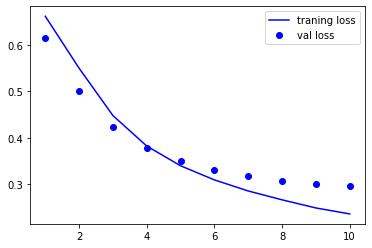

In [27]:


plt.plot( range(1 , len(data) + 1) ,data['loss']  , 'b' , label = 'traning loss' )
plt.plot( range(1 , len(data) + 1) ,data['val_loss']  , 'bo' , label = 'val loss' )

plt.legend()



# Training and validation accuracy


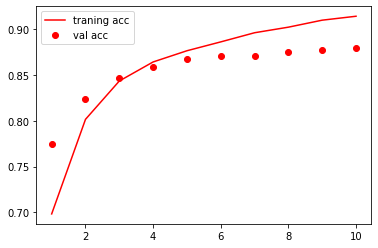

In [28]:
plt.plot( range(1 , len(data) + 1) ,data['binary_accuracy']  , 'r' , label = 'traning acc' )
plt.plot( range(1 , len(data) + 1) ,data['val_binary_accuracy']  , 'ro' , label = 'val acc' )

plt.legend()


# Export The Model

In [33]:
exported_model = tf.keras.Sequential([
    vectorize_layer , model , layers.Activation('sigmoid')
])



In [35]:
exported_model.compile(optimizer = 'Adam'  , loss = losses.BinaryCrossentropy(from_logits=False) , 
                      metrics = ['accuracy'])




In [113]:
# Test it with `raw_test_ds`, which yields raw strings


text =  ['this a brilliant amd fantastic movie' , 
     'awful movie i never gonna watch it again'
            , 'legendary movie' , 'it can be better' , 'i have a good sence about this movie' , 'not good enough they expend lots of money on it' ,
        'i didnt like the movie']


a = exported_model.predict(text)





final = pd.DataFrame(a , columns = ['Sentiment of a user' ] , index = text)

1/1 [==============================] - 0s 25ms/step


In [114]:
final['Sentiment of a user'] = np.where(final['Sentiment of a user'] > 0.5 , 'positive' , 'negative')

In [115]:
final

,Sentiment of a user
this a brilliant amd fantastic movie,positive
awful movie i never gonna watch it again,negative
legendary movie,positive
it can be better,positive
i have a good sence about this movie,positive
not good enough they expend lots of money on it,negative
i didnt like the movie,negative
